<a href="https://colab.research.google.com/github/JonHaz/Ethereum/blob/main/Craft_a_Story_from_a_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's look at Ethereum Blck Data for the month of January

In [106]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [107]:
# Save output in a variable `df`

%%bigquery --project storied-sound-253213 df
SELECT
   timestamp, number, miner, difficulty, size, transaction_count, gas_limit, gas_used
FROM `bigquery-public-data.crypto_ethereum.blocks` 
WHERE DATE(timestamp) BETWEEN "2021-01-21" AND "2021-01-31"

In [108]:
df.head()

,timestamp,number,miner,difficulty,size,transaction_count,gas_limit,gas_used
0,2021-01-31 18:19:04+00:00,11765382,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,4512655735889566,33289,121,12475600,12464115
1,2021-01-31 02:56:42+00:00,11761165,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,4341680275455355,39230,100,12457194,11247012
2,2021-01-31 09:33:07+00:00,11762976,0x2f731c3e8cd264371ffdb635d07c14a6303df52a,4453751489112643,51544,276,12481662,12462200
3,2021-01-31 14:51:08+00:00,11764443,0x2f731c3e8cd264371ffdb635d07c14a6303df52a,4500374209921514,39010,138,12499988,12486160
4,2021-01-31 16:53:05+00:00,11764967,0x2f731c3e8cd264371ffdb635d07c14a6303df52a,4445204192158588,46774,227,12499988,12495976


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71465 entries, 0 to 71464
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          71465 non-null  datetime64[ns, UTC]
 1   number             71465 non-null  int64              
 2   miner              71465 non-null  object             
 3   difficulty         71465 non-null  object             
 4   size               71465 non-null  int64              
 5   transaction_count  71465 non-null  int64              
 6   gas_limit          71465 non-null  int64              
 7   gas_used           71465 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(2)
memory usage: 4.4+ MB


First let's analyze the columns 'size' and 'transaction_count'

In [110]:
df[['size','transaction_count']].describe()

,size,transaction_count
count,71465.000000,71465.000000
mean,44250.298174,183.449157
std,11875.228608,63.321700
min,518.000000,0.000000
25%,38987.000000,148.000000
50%,44818.000000,181.000000
75%,50330.000000,215.000000
max,205974.000000,595.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ab70b5c90>,
      dtype=object)

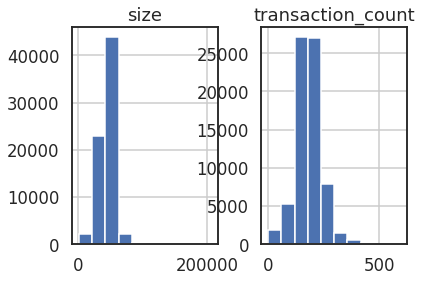

In [111]:
df[['size','transaction_count']].hist()

In [112]:
df[['size','transaction_count']].corr()

,size,transaction_count
size,1.000000,0.588667
transaction_count,0.588667,1.000000


How many miners do we have during this period?

In [113]:
df['miner'].groupby(df['miner']).count().sort_values(ascending=False).count()

91

The top 10% of Miners make up 82% of the the blocks during this month

```
# This is formatted as code
```



In [114]:
blocks = df['miner'].groupby(df['miner']).count().sort_values(ascending=False)

top_9 = blocks.nlargest(9)
top_9.sum()

top_9.sum()/blocks.sum()

0.8242076540964108

In terms of number of blocks what does that distribution look like?

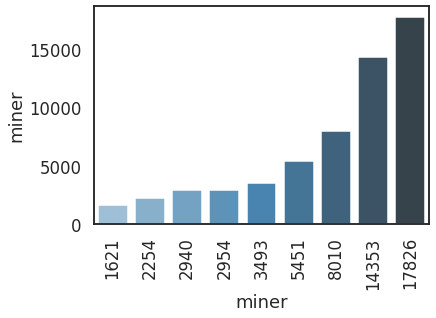

In [115]:

import seaborn as sns
import matplotlib.pyplot as plt

x=top_9.index
y = top_9
plt.xticks(rotation=90)
sns.barplot(x=x, y=y, data=blocks,
            label="Total", palette="Blues_d")


What percentage of blocks don't go through because the gas limit was too low

In [116]:
gas = df.loc[:,['miner','gas_limit','gas_used']]

#gas.count(gas['gas_limit'] == gas['gas_used'])
gas['gas_left'] = (gas['gas_limit'] - gas['gas_used'])
gas.head()

,miner,gas_limit,gas_used,gas_left
0,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12475600,12464115,11485
1,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12457194,11247012,1210182
2,0x2f731c3e8cd264371ffdb635d07c14a6303df52a,12481662,12462200,19462
3,0x2f731c3e8cd264371ffdb635d07c14a6303df52a,12499988,12486160,13828
4,0x2f731c3e8cd264371ffdb635d07c14a6303df52a,12499988,12495976,4012


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ab67270d0>,
      dtype=object)

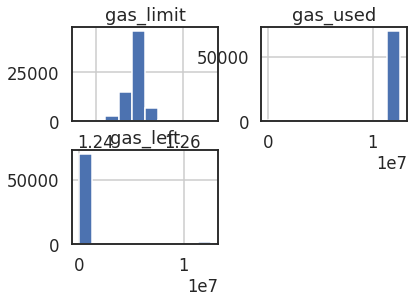

In [117]:
gas.hist()

In [118]:
#There are a lot of blocks that don't use any gas
gas.sort_values(by='gas_used', ascending=True)
gas[gas['gas_used']==0].count()

miner        1441
gas_limit    1441
gas_used     1441
gas_left     1441
dtype: int64

How much ETH was awareded to the top 9 miners?

In [119]:
# add the top 9 miners to a list
miners = list(top_9.index)

In [120]:
#creating a new column to calculate ethereum awarded 
# 200 Gwei is tha maximum fee per Gas
# Total fee will be: Gas units (limit) * Gas price per unit i.e 21,000 * 200 = 4,200,000 gwei or 0.0042 ETH
# I am using gas used because if there is any gas left over it will be refunded

gas['eth_awarded'] = gas['gas_used'] * 200 * 0.000000001
gas['eth_projected'] = gas['gas_limit'] * 200 * 0.000000001
gas.head()

,miner,gas_limit,gas_used,gas_left,eth_awarded,eth_projected
0,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12475600,12464115,11485,2.492823,2.495120
1,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12457194,11247012,1210182,2.249402,2.491439
2,0x2f731c3e8cd264371ffdb635d07c14a6303df52a,12481662,12462200,19462,2.492440,2.496332
3,0x2f731c3e8cd264371ffdb635d07c14a6303df52a,12499988,12486160,13828,2.497232,2.499998
4,0x2f731c3e8cd264371ffdb635d07c14a6303df52a,12499988,12495976,4012,2.499195,2.499998


The projected and awarded amount of ETH are very close so I can just visualize the ETH awarded by miner

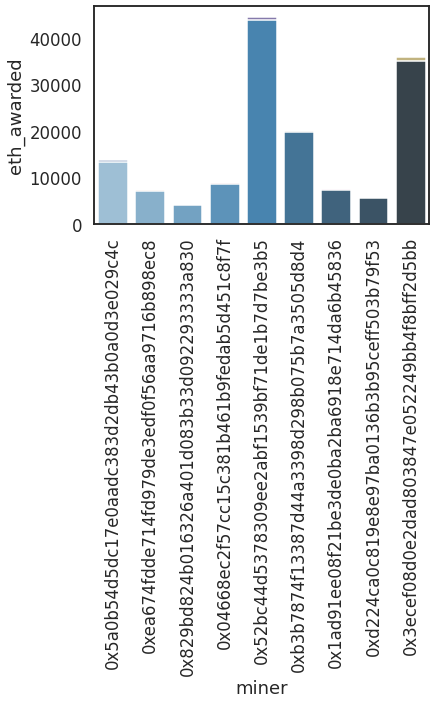

In [121]:
#filtering by top 9 miners
top_gas =gas[gas['miner'].isin(miners)]

#creating series to display revenues for top miners
top_eth = top_gas[['miner','eth_awarded','eth_projected']].groupby(top_gas['miner']).sum()
top_eth['miner'] = top_eth.index
#top_eth.info()
#sns.set_theme(style="white", context="talk")
plt.xticks(rotation=90)
sns.barplot(x=x,y='eth_projected', data=top_eth)
sns.barplot(x=x,y="eth_awarded", data=top_eth, palette="Blues_d")

In [122]:
#top_9['miner'] = top_9.index
#top_eth.reset_index(drop=True, inplace=True)
#top_9.reset_index(drop=True, inplace=True)
#top_eth.merge(top_9, how='inner', left_on='miner', right_on='miner')

TypeError: ignored